## Replicate Spatial Autocorrelation Code with Cardinal Data

Author: Max Gold

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats
import seaborn as sns

### BVI analysis
import pysal as ps
from pysal import lib
from esda.moran import Moran_BV, Moran_Local_BV

/home/mpgold/.conda/envs/pysal/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
base_fold = '../../data/'

In [2]:
cdata = sc.read_h5ad(os.path.join(base_fold, 'cardinal_maldi_data.h5ad'))

In [3]:
fcdata = cdata.copy()
fcdata.obs['X'] = fcdata.obs['x']
fcdata.obs['Y'] = fcdata.obs['ty']

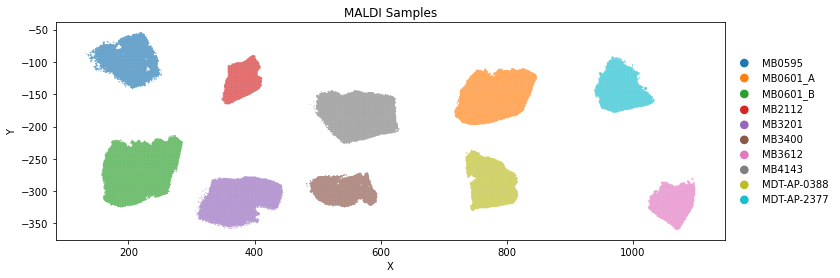

In [5]:
fig,ax = plt.subplots(figsize=(12,4))
sc.pl.scatter(fcdata, x='X', y='Y', color='sample',ax=ax, title='MALDI Samples')
# plt.title("")
# ax.savefig("fig6s-maldiplot-allsamp.png", dpi=300, bbox_inches='tight')

In [7]:
osamp = list(sorted(cdata[cdata.obs['subtype']=='SHHa'].obs['sample'].unique()))

In [8]:
bsamp = list(sorted(cdata[cdata.obs['subtype']=='SHHb'].obs['sample'].unique()))

In [9]:
nsamps = bsamp + osamp

In [10]:
newsamp = ['MB4113' if (x == 'MB4143') else x for x in cdata.obs['sample']]

In [11]:
cdata

AnnData object with n_obs × n_vars = 62469 × 1342
    obs: 'run', 'x', 'y', 'ty', 'clust', 'clust_ord', 'sample', 'subtype', 'old_leiden'
    var: 'mz', 'metabolite', 'gm'
    uns: 'old_leiden_colors'

In [12]:
rrup = []
brup = []
for samp in nsamps:
    mro = cdata[cdata.obs['sample']==samp]
    kv=24
    spat = mro.obs[['x', 'ty']].values
    w = ps.lib.weights.KNN(spat, k=kv)
    w.transform = 'R'
    yudf = pd.DataFrame(mro.X.toarray(), columns=mro.var['metabolite'])
    taur_vals = yudf['taurine'].values
    g_vals = yudf['guanine'].values   
    
    res = Moran_Local_BV(taur_vals.astype("float64"), g_vals.astype("float64"),w)
    ri = res.Is
    
    rru = Moran_BV(taur_vals.astype("float64"), g_vals.astype("float64"),w)
    rrup.append([samp,float(rru.I)])
    
    r,p = stats.spearmanr(taur_vals, g_vals)
    
    if samp == 'MB4143':
        samp = 'MB4113'
    for i in ri:
        brup.append([samp, i])
    print(samp,'...',rru.I, '...', np.mean(ri), '...', np.median(ri), '...', r, )
# res.Is    

MB0595 ... -0.4188365574863643 ... -0.41876625930618855 ... -0.17484369338496553 ... -0.36256777685114105
MB0601_A ... -0.08994091343460489 ... -0.08993022272814649 ... 0.005477324414986068 ... -0.014911077423858976
MB0601_B ... -0.04840492906157726 ... -0.04840031423375178 ... 0.0003655864321662542 ... 0.06060372798288465
MB2112 ... -0.35633734105888965 ... -0.35622309375492717 ... -0.17348262584178215 ... -0.3298618748167131
MB3400 ... -0.1638984402170946 ... -0.16385991213993964 ... -0.029643814482313485 ... -0.05888271091313812
MB3612 ... -0.2837246634121195 ... -0.28364948464597955 ... -0.16927165593238422 ... -0.2565286094729726
MB3201 ... 0.10225134619817736 ... 0.1022381268903301 ... 0.002489480458485761 ... 0.18037616494718528
MB4113 ... 0.34530469189298246 ... 0.3452628975705553 ... 0.09244678102928988 ... 0.2961399142238073
MDT-AP-0388 ... 0.027288996988302398 ... 0.027283965831040553 ... 0.005911216132173876 ... 0.13757382238710422
MDT-AP-2377 ... -0.010749862127834025 ... 

In [13]:
rpdf = pd.DataFrame(rrup, columns = ['sample', 'BVI'])
rpdf['Subtype'] = ['LSGN' for _ in range(len(bsamp))] + ['Other' for _ in range(len(osamp))]

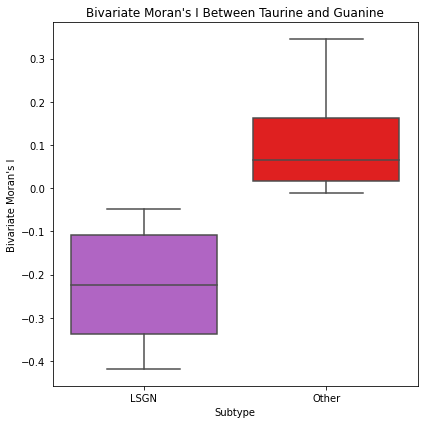

In [14]:
fig,ax = plt.subplots(figsize=(6,6))
sns.boxplot(data=rpdf, x='Subtype', y='BVI', palette=['mediumorchid', 'red'],ax=ax)
ax.set_xlabel("Subtype")
ax.set_ylabel("Bivariate Moran's I")
ax.set_title("Bivariate Moran's I Between Taurine and Guanine")
fig.tight_layout()
plt.savefig("cardinal_sample_bvi.png", dpi=300)
plt.savefig("cardinal_sample_bvi.pdf", dpi=300)

In [15]:
rpdf = pd.DataFrame(brup, columns = ['sample', 'Local BVI'])
pal = ['mediumorchid' for _ in range(len(bsamp))] + ['green' for _ in range(len(osamp))]

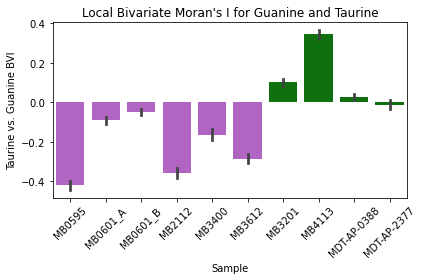

In [16]:
ax = sns.barplot(data=rpdf, x='sample', y='Local BVI', palette= pal)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Taurine vs. Guanine BVI")
ax.set_xlabel("Sample")
ax.set_title("Local Bivariate Moran's I for Guanine and Taurine")
plt.tight_layout()
plt.savefig("cardinal_lbvi_taurine_guanine.png", dpi=300)
plt.savefig("cardinal_lbvi_taurine_guanine.pdf", dpi=300)